In [1]:
import pandas as pd
import numpy as np
from numpy import savetxt
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
import itertools

In [2]:
pip install econml

     |████████████████████████████████| 3.3 MB 12.0 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 356 kB 63.4 MB/s 
     |████████████████████████████████| 123 kB 57.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491655 sha256=c9c7721fcd7e11c16fad1fa1f4246bed8d495d42193026fac1558c975dbc53ce
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [3]:
import econml
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Main imports
from econml.ortho_forest import DMLOrthoForest, DROrthoForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from econml.metalearners import TLearner

from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import graphviz

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression
import matplotlib.pyplot as plt

%matplotlib inline

# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [5]:
case_id_col = "Case ID"
activity_col = "Activity"
resource_col = "org:resource"
timestamp_col = "time:timestamp"

treatment = 'treatment'
outcome = 'duration'

In [6]:
dynamic_cat_cols = ["Activity", 'org:resource', 'Action', 'EventOrigin', 'lifecycle:transition']
static_cat_cols = ['ApplicationType', 'LoanGoal']
dynamic_num_cols = ['FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', "open_cases", "month", "weekday", "hour"]
static_num_cols = ['RequestedAmount', 'CreditScore', 'timesincefirstcase', 'duration', 'treatment']

In [7]:
# Connect with Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
df2 = pd.read_csv('gdrive/My Drive/Data/data_bpic17_readyToUse.csv')

In [9]:
# Prepare data for time of activity treatment
train, test = train_test_split(df2, test_size=0.2, shuffle=False)
train, valid = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment, case_id_col], axis=1)
features_test = valid.drop([outcome, treatment, case_id_col], axis=1)


cat_confound_cols = ['LoanGoal', 'ApplicationType']
num_confound_cols = features.columns.difference(cat_confound_cols)

cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['RequestedAmount', 'CreditScore']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()
W1 = scaler.fit_transform(features[[c for c in num_confound_cols]].to_numpy())
W2 = pd.get_dummies(features[cat_confound_cols]).to_numpy()
W = np.concatenate([W1, W2], axis=1)
X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

X1_test = scaler.fit_transform(features_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(features_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

In [10]:
N_trees = [200]
Min_leaf_size = [20]
Max_depth = [30]
Subsample_ratio = [0.4]
Lambda_reg = [0.01]

In [11]:
# preparing the test set
f_test = test.drop([outcome, treatment], axis=1)
X1_test = scaler.fit_transform(f_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(f_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

    
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=106
       )
    
    ortho_model = est.fit(Y, T, X=X, W=W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = test
    df_results['Treatment Effects'] = treatment_effects

(200, 20, 30, 0.4, 0.01)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend Lok

In [20]:
df_results.to_csv('gdrive/My Drive/Results/dataframe_with_results_BPIC17', index=False)

In [21]:
train, test = train_test_split(df2, test_size=0.2, shuffle=False)
train = train[train[treatment]==0]
# train, valid = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment, case_id_col], axis=1)
features_test = valid.drop([outcome, treatment, case_id_col], axis=1)


cat_confound_cols = ['LoanGoal', 'ApplicationType']
num_confound_cols = features.columns.difference(cat_confound_cols)

cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['RequestedAmount', 'CreditScore']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()

X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

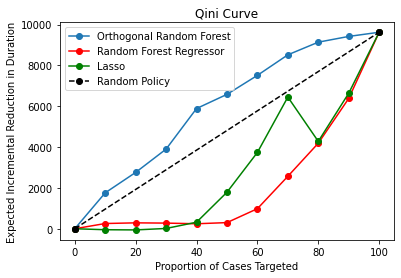

In [22]:
# df_results = test
# df_results['Treatment Effects'] = treatment_effects


pred = Lasso()
pred.fit(X, Y)

pred2 = RandomForestRegressor()
pred2.fit(X, Y)

yhat_test = pred.predict(X_test)
df_results['predictions_lasso'] = yhat_test

yhat_test2 = pred2.predict(X_test)
df_results['predictions_RF'] = yhat_test2

net_value = [0]
net_value2 = [0]
net_value3 = [0]

percentages = [10,20,30,40,50,60,70,80,90,100]

for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'Treatment Effects')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)


for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nlargest(num,'predictions_lasso')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value2.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nlargest(num,'predictions_RF')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value3.append(reduction)


plt.plot([0]+percentages, net_value, label="Orthogonal Random Forest", marker="o")
plt.plot([0]+percentages, net_value3, label="Random Forest Regressor", marker="o", color='Red')
plt.plot([0]+percentages, net_value2, label="Lasso", marker="o", color='Green')
plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
         linestyle='dashed')
plt.xlabel('Proportion of Cases Targeted')
plt.ylabel('Expected Incremental Reduction in Duration')
plt.legend(loc='best')
plt.title('Qini Curve')

plt.savefig('gdrive/My Drive/Results/bpic_17_qini_withBaseline-1', format='png', dpi=300)


Net value ORF: [0, 1759.2144262424608, 2758.028116172427, 3899.750882050179, 5885.819697695384, 6580.113663027521, 7510.6946154743055, 8516.038597233637, 9135.440787408203, 9416.825170809978, 9621.553259826112]

Net value Lasso: [0, -48.49236678170483, -57.750159271655434, 13.661995011299837, 319.16791051385417, 1787.7396331082873, 3737.5854620896534, 6447.502569681543, 4276.9337553131045, 6635.402754909148, 9621.553259826112]

Net value RF: [0, 215.5867992988599, 246.3744198632221, 348.3472186578365, 302.1371895323455, 310.79094972651, 895.7110635071895, 2287.9019312502314, 4176.4584316401815, 6163.19223161121, 9621.553259826112]



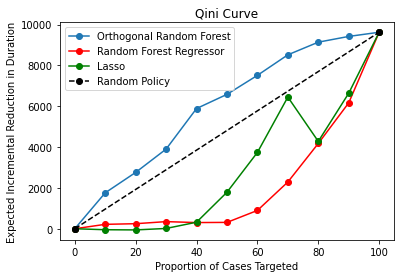

In [23]:
# df_results = test
# df_results['Treatment Effects'] = treatment_effects


pred = Lasso()
pred.fit(X, Y)

pred2 = RandomForestRegressor()
pred2.fit(X, Y)

yhat_test = pred.predict(X_test)
df_results['predictions_lasso'] = yhat_test

yhat_test2 = pred2.predict(X_test)
df_results['predictions_RF'] = yhat_test2

net_value = [0]
net_value2 = [0]
net_value3 = [0]

percentages = [10,20,30,40,50,60,70,80,90,100]

for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'Treatment Effects')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)


for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nlargest(num,'predictions_lasso')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value2.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nlargest(num,'predictions_RF')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value3.append(reduction)


plt.plot([0]+percentages, net_value, label="Orthogonal Random Forest", marker="o")
plt.plot([0]+percentages, net_value3, label="Random Forest Regressor", marker="o", color='Red')
plt.plot([0]+percentages, net_value2, label="Lasso", marker="o", color='Green')
plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
         linestyle='dashed')
plt.xlabel('Proportion of Cases Targeted')
plt.ylabel('Expected Incremental Reduction in Duration')
plt.legend(loc='best')
plt.title('Qini Curve')

plt.savefig('gdrive/My Drive/Results/bpic_17_qini_withBaseline-2', format='png', dpi=300)
print(f"Net value ORF: {net_value}\n")
print(f"Net value Lasso: {net_value2}\n")
print(f"Net value RF: {net_value3}\n")

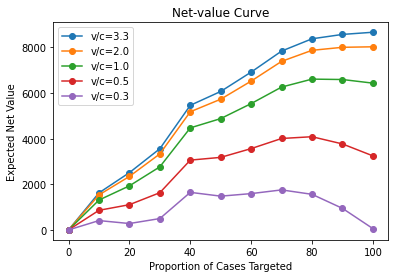

In [24]:
value = [1]
cost = [3,1,2,0.5,0.2]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    net_value = [0]
    v = i[0]
    c = i[1]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (n_treated*c) 
        net_value.append(net_val)
    #     net_value.append(reduction)

    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random Policy",  marker="o", color='Gray',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Net Value')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('gdrive/My Drive/Results/bpic_17_netValue-1.png', format='png', dpi=300)

Net values (1, 0.3): [0, 1624.2144262424608, 2510.228116172427, 3559.550882050179, 5461.9196976953845, 6070.113663027521, 6918.794615474306, 7839.838597233637, 8377.940787408203, 8569.625170809977, 8665.153259826113]
Net values (1, 0.5): [0, 1534.2144262424608, 2345.028116172427, 3332.750882050179, 5179.319697695384, 5730.113663027521, 6524.1946154743055, 7389.038597233637, 7872.940787408203, 8004.825170809978, 8027.5532598261125]
Net values (1, 1): [0, 1309.2144262424608, 1932.028116172427, 2765.750882050179, 4472.819697695384, 4880.113663027521, 5537.6946154743055, 6262.038597233637, 6610.440787408203, 6592.825170809978, 6433.5532598261125]
Net values (1, 2): [0, 859.2144262424608, 1106.028116172427, 1631.750882050179, 3059.819697695384, 3180.1136630275214, 3564.6946154743055, 4008.038597233637, 4085.4407874082026, 3768.825170809978, 3245.5532598261125]
Net values (1, 3): [0, 409.21442624246083, 280.02811617242696, 497.7508820501789, 1646.819697695384, 1480.1136630275214, 1591.694615

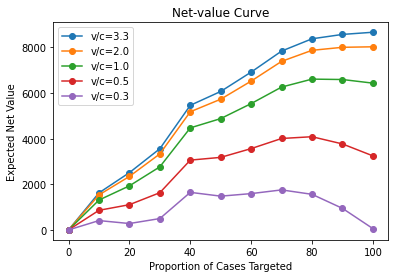

In [25]:
value = [1]
cost = [3,1,2,0.5,0.2]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    net_value = [0]
    v = i[0]
    c = i[1]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (n_treated*c) 
        net_value.append(net_val)
    #     net_value.append(reduction)
    print(f"Net values {i}: {net_value}")
    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random Policy",  marker="o", color='Gray',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Net Value')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('gdrive/My Drive/Results/bpic_17_netValue-2.png', format='png', dpi=300)